In [1]:
%%capture
!pip install tables
!pip install keras-tuner
import os, gc, pickle, datetime, scipy.sparse
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from colorama import Fore, Back, Style

from sklearn.model_selection import GroupKFold, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD,PCA
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from cycler import cycler
from IPython.display import display

import scipy.sparse
import scprep

def correlation_score(y_true, y_pred):
    if type(y_true) == pd.DataFrame: y_true = y_true.values
    if type(y_pred) == pd.DataFrame: y_pred = y_pred.values
    corrsum = 0
    for i in range(y_true.shape[0]):
        corrsum += np.corrcoef(y_true[i], y_pred[i])[1, 0]
    return corrsum / len(y_true)

def negative_correlation_loss(y_true, y_pred):
    my = K.mean(tf.convert_to_tensor(y_pred), axis=1)
    my = tf.tile(tf.expand_dims(my, axis=1), (1, tf.shape(y_true)[1]))
    ym = y_pred - my
    r_num = K.sum(tf.multiply(y_true, ym), axis=1)
    r_den = tf.sqrt(K.sum(K.square(ym), axis=1) * float(tf.shape(y_true)[-1]))
    r = tf.reduce_mean(r_num / r_den)
    return - r

!pip install keras_tuner
import keras_tuner
from sklearn.model_selection import train_test_split
import scprep

!pip install --upgrade --force-reinstall tensorflow
import math
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
from tensorflow.keras.layers import Dense, Input, Concatenate, Dropout, BatchNormalization
LR_START = 0.01
BATCH_SIZE = 512

best_hp = keras_tuner.HyperParameters()
best_hp.values = {'reg1': 0.0001,
                'reg2': 3.307e-07,
                'units1': 1024,
                'units2': 1024,
                'units3': 1024,
                'lr': 0.001
                 }

def create_model(hp=best_hp):
    
    #reg1 = 8e-5
    #reg2 = 2e-5
    # reg1 = 9.613e-06
    # reg2 = 1e-07
    reg1 = hp.Float("reg1", min_value=1e-8, max_value=1e-4, sampling="log")
    reg2 = hp.Float("reg2", min_value=1e-8, max_value=1e-4, sampling="log")
    
    REG1 = tf.keras.regularizers.l2(reg1)
    REG2 = tf.keras.regularizers.l2(reg2)
    
    DROP = 0.1

    activation = 'selu'
    inputs = Input(shape =(X.shape[1],))

    x0 = Dense(hp.Choice('units1', [1024,512,256]), 
              kernel_regularizer = REG1,
              activation = activation,
             )(inputs)
    x0 = Dropout(DROP)(x0)
    
    x1 = Dense(hp.Choice('units2', [1024,512,256]), 
               kernel_regularizer = REG1,
               activation = activation,
             )(x0)
    x1 = Dropout(DROP)(x1)
    
    x2 = Dense(hp.Choice('units3', [1024,512,256]), 
               kernel_regularizer = REG1,
               activation = activation,
             )(x1) 
    x2= Dropout(DROP)(x2)

    x = Concatenate()([
                x0, 
                x1, 
                x2
                ])
    x = Dense(Y.shape[1], 
                kernel_regularizer = REG2,
                activation='linear',
                )(x)
    model = Model(inputs, x)
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp.Float("lr", min_value=1e-3, max_value=1e-0)),
        metrics = [negative_correlation_loss],
        loss = 'mse'
         )
    return model

ModuleNotFoundError: No module named 'tensorflow'

In [4]:
X = np.load("/kaggle/working/gene_annot/train_multi_geneactivity.npy")
inputs_both_128 = np.load("../multi_pca/inputs_both_128.npy")
multi_X_train = inputs_both_128[:10592]
X = np.hstack([X,multi_X_train])
targets = scipy.sparse.load_npz("../sparse/train_multi_targets_values.sparse.npz")
targets = targets[:10592]
targets = scprep.filter.remove_empty_genes(targets)
# Normalize the targets row-wise: This doesn't change the correlations,
# and negative_correlation_loss depends on it
targets -= targets.mean(axis=1).reshape(-1, 1)
targets /= targets.std(axis=1).reshape(-1, 1)

with np.load('../sparse/train_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index = data['index']

with np.load('../sparse/test_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index_t = data['index']

metadata_df = pd.read_csv('../../input/open-problems-multimodal/metadata.csv', index_col='cell_id')
metadata_df = metadata_df[metadata_df.technology=="multiome"]
meta = metadata_df.reindex(cell_index)
meta = meta.iloc[:10592]

In [5]:
Y = targets

In [14]:
import warnings
warnings.filterwarnings("ignore")
VERBOSE = 0

pred_train = np.zeros_like(Y)

N_SPLIT = 3
#kf = KFold(n_splits=N_SPLIT, shuffle=True, random_state=42)
kf = KFold(n_splits = N_SPLIT)

score_list = []

for fold,(idx_tr, idx_va) in enumerate(kf.split(X)):
    
    X_tr = X[idx_tr]
    y_tr = Y[idx_tr]
    
    X_va = X[idx_va]
    y_va = Y[idx_va]
    
    #day = (meta.iloc[idx_va].iloc[0]).day
    
    #model = my_model(n_inputs=X.shape[1],n_outputs=Y.shape[1],reg1=reg1,reg2=reg2,loss = negative_correlation_loss)
    model = create_model()
    #weights = meta.iloc[idx_tr].apply(lambda x:after_ratio[x.cell_type],axis=1)    
    
    lr = ReduceLROnPlateau(
                monitor = "val_loss",
                factor = 0.9, 
                patience = 4, 
                verbose = VERBOSE)
    
    es = EarlyStopping(
                monitor = "val_loss",
                patience = 30, 
                verbose = VERBOSE,
                mode = "min", 
                restore_best_weights = True)

    model.fit(X_tr,
              y_tr,
              validation_data=(X_va,y_va),
              epochs =500,
              verbose = VERBOSE,
              batch_size=256,
              callbacks = [es,lr]
             )
    y_va_pred = model.predict(X_va)
    
    print(f'\n --------- FOLD {fold} -----------')
    
    corrscore = correlation_score(y_va, y_va_pred)
    pred_train[idx_va] = y_va_pred
    
    print(f"Fold {fold}, correlation =  {corrscore:.5f}")
   
    model.save(f"./submissions/multi_model_{fold}")

    print('model saved')
        
    del X_tr,X_va,y_tr,y_va
    gc.collect()
    score_list.append(corrscore)
    
# Show overall score
print(f"{Fore.GREEN}{Style.BRIGHT}Mean corr = {np.array(score_list).mean():.5f}{Style.RESET_ALL}")

111/111 [==============================] - 2s 17ms/step

 --------- FOLD 0 -----------
Fold 0, correlation =  0.66311
model saved
111/111 [==============================] - 2s 13ms/step

 --------- FOLD 1 -----------
Fold 1, correlation =  0.65980
model saved
111/111 [==============================] - 2s 13ms/step

 --------- FOLD 2 -----------
Fold 2, correlation =  0.63075
model saved
Mean corr = 0.65122


In [ ]:
X = np.load("/kaggle/working/gene_annot/train_multi_geneactivity.npy")
inputs_both_128 = np.load("../multi_pca/inputs_both_128.npy")
multi_X_train = inputs_both_128[:10592]
X = np.hstack([X,multi_X_train])
targets = scipy.sparse.load_npz("../sparse/train_multi_targets_values.sparse.npz")
targets = targets[:10592]
targets = scprep.filter.remove_empty_genes(targets)
# Normalize the targets row-wise: This doesn't change the correlations,
# and negative_correlation_loss depends on it
targets -= targets.mean(axis=1).reshape(-1, 1)
targets /= targets.std(axis=1).reshape(-1, 1)

with np.load('../sparse/train_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index = data['index']

with np.load('../sparse/test_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index_t = data['index']

metadata_df = pd.read_csv('../../input/open-problems-multimodal/metadata.csv', index_col='cell_id')
metadata_df = metadata_df[metadata_df.technology=="multiome"]
meta = metadata_df.reindex(cell_index)
meta = meta.iloc[:10592]

In [2]:
%%capture
!pip install tables
!pip install --upgrade --force-reinstall tensorflow
!pip install keras-tuner
import os, gc, pickle, datetime, scipy.sparse
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from colorama import Fore, Back, Style

from sklearn.model_selection import GroupKFold, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD,PCA
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from cycler import cycler
from IPython.display import display

import scipy.sparse
import scprep

def correlation_score(y_true, y_pred):
    corrsum = 0
    for i in range(y_true.shape[0]):
        corrsum += np.corrcoef(y_true[i], y_pred[i])[1, 0]
    return corrsum / len(y_true)

def negative_correlation_loss(y_true, y_pred):
    my = K.mean(tf.convert_to_tensor(y_pred), axis=1)
    my = tf.tile(tf.expand_dims(my, axis=1), (1, tf.shape(y_true)[1]))
    ym = y_pred - my
    r_num = K.sum(tf.multiply(y_true, ym), axis=1)
    r_den = tf.sqrt(K.sum(K.square(ym), axis=1) * float(tf.shape(y_true)[-1]))
    r = tf.reduce_mean(r_num / r_den)
    return - r

!pip install keras_tuner
import keras_tuner
from sklearn.model_selection import train_test_split
import scprep

import math
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
from tensorflow.keras.layers import Dense, Input, Concatenate, Dropout, BatchNormalization


2022-11-06 21:37:12.815155: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-06 21:37:12.962503: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-06 21:37:12.999639: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-06 21:37:13.629033: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [172]:
LR_START = 0.01
BATCH_SIZE = 512

def create_model():
    
    reg1 = 9.613e-06
    reg2 = 1e-07
    REG1 = tf.keras.regularizers.l2(reg1)
    REG2 = tf.keras.regularizers.l2(reg2)
    DROP = 0.1

    activation = 'selu'
    inputs = Input(shape =(X.shape[1],))

    x0 = Dense(512, 
              kernel_regularizer = REG1,
              activation = activation,
             )(inputs)
    x0 = Dropout(DROP)(x0)
    
    
    x1 = Dense(1024, 
               kernel_regularizer = REG1,
               activation = activation,
             )(x0)
    x1 = Dropout(DROP)(x1)
    
    
    x2 = Dense(1024, 
               kernel_regularizer = REG1,
               activation = activation,
             )(x1) 
    x2= Dropout(DROP)(x2)
    
    x3 = Dense(Y.shape[1],
               kernel_regularizer = REG1,
               activation = activation,
             )(x2)
    x3 = Dropout(DROP)(x3)

         
    x = Concatenate()([
                x0, 
                x1, 
                x2, 
                x3
                ])
    
    x = Dense(Y.shape[1], 
                kernel_regularizer = REG2,
                activation='linear',
                )(x)
    
    
    model = Model(inputs, x)
    

    return model

In [14]:
targets = scipy.sparse.load_npz("../sparse/train_multi_targets_values.sparse.npz")
targets = scprep.filter.remove_empty_genes(targets)
# Normalize the targets row-wise: This doesn't change the correlations,
# and negative_correlation_loss depends on it
targets -= targets.mean(axis=1).reshape(-1, 1)
targets /= targets.std(axis=1).reshape(-1, 1)
targets = np.array(targets)
svd = TruncatedSVD(n_components = 512,random_state = 1)
Y = svd.fit_transform(targets)
inputs_both_128 = np.load("../multi_pca/inputs_both_128.npy")
X = inputs_both_128[:len(targets_copy),:40]
with np.load('../sparse/train_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index = data['index']
with np.load('../sparse/test_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index_t = data['index']
metadata_df = pd.read_csv('../../input/open-problems-multimodal/metadata.csv', index_col='cell_id')
metadata_df = metadata_df[metadata_df.technology=="multiome"]
meta = metadata_df.reindex(cell_index)

In [143]:
svd = TruncatedSVD(n_components = 512,random_state = 1)
svd.fit(targets_copy[day4_donor1])

TruncatedSVD(n_components=512, random_state=1)

In [182]:
svd = TruncatedSVD(n_components = 512,random_state = 1)
svd.fit(targets_copy[day7_donor1])
Y = svd.transform(targets_copy)

In [185]:
Y

array([[ 75.7475    ,  26.229336  ,  17.50476   , ...,  -1.0983195 ,
          2.4313428 ,  -1.379859  ],
       [ 90.88657   , -22.890305  ,   0.17320499, ...,   3.8807917 ,
         -1.4330426 ,  -0.88454574],
       [ 80.71592   ,  -5.2079225 , -15.398834  , ...,   2.7719083 ,
          0.43796664,  -2.7065501 ],
       ...,
       [ 98.39515   , -25.125317  ,  -1.9855108 , ...,   2.3576763 ,
         -0.65535045,  -2.2070384 ],
       [ 76.20684   ,  13.359733  , -23.053707  , ...,   3.140378  ,
          3.0544224 ,   0.48811173],
       [ 85.19872   , -10.540954  ,  -7.3463173 , ...,   2.660223  ,
          0.55914426,   0.25101855]], dtype=float32)

In [292]:
inputs_both_128 = np.load("../multi_pca/inputs_both_128.npy")
X = inputs_both_128[:len(targets)]
X_copy = X.copy()

In [15]:
Y_copy = Y.copy()
X_copy = X.copy()
targets_copy = targets.copy()

In [186]:
X = X_copy[day7_donor1][:1000,:40]
Y = svd.transform(targets_copy[day7_donor1][:1000])[:,:64]
targets = targets_copy[day7_donor1][:1000]
print(X.shape)
print(Y.shape)
print(targets.shape)

(1000, 40)
(1000, 64)
(1000, 22858)


In [368]:
X = np.load("/kaggle/working/gene_annot/train_multi_geneactivity_day_7.npy")

In [123]:
X_tr = X_copy[day4_donor1][:2000]
X_va = X_copy[day7_donor1][:2000]
y_tr = svd.transform(targets_copy[day4_donor1][:2000])
y_va = svd.transform(targets_copy[day7_donor1][:2000])

In [26]:
X_va.shape

(6960, 40)

In [187]:
import warnings
warnings.filterwarnings("ignore")

VERBOSE = 0
N_SPLIT = 3
#kf = KFold(n_splits=N_SPLIT, shuffle=True, random_state=42)
kf = KFold(n_splits = N_SPLIT)

scores = []
pca_scores = []
pred_train = np.zeros_like(Y)

for fold,(idx_tr, idx_va) in enumerate(kf.split(X)):
    
    X_tr = X[idx_tr]
    y_tr = Y[idx_tr]
    
    X_va = X[idx_va]
    y_va = Y[idx_va] 

    model = create_model()

    lr = ReduceLROnPlateau(
                monitor = "val_loss",
                factor = 0.9, 
                patience = 4, 
                verbose = VERBOSE)

    es = EarlyStopping(
                monitor = "val_loss",
                patience = 30, 
                verbose = VERBOSE,
                mode = "min", 
                restore_best_weights = True)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss = 'mse',
                  metrics=None)
    model.fit(X_tr,
              y_tr,
              validation_data=(X_va,y_va),
              epochs =500,
              verbose = VERBOSE,
              batch_size=256,
              callbacks = [es,lr]
             )
    y_va_pred = model.predict(X_va)
    corrscore = correlation_score(targets[idx_va], y_va_pred@svd.components_[:64])
    scores.append(corrscore)
    pca_corrscore = correlation_score(y_va[:,:64], y_va_pred[:,:64])
    pca_scores.append(pca_corrscore)

    print(f'\n --------- FOLD {fold} -----------')
    print(f'Mean squared error = {np.round(mean_squared_error(y_va,y_va_pred),2)}')
    print(f'Correlation = {corrscore:.5f}')
    print(f'PCA Correlation = {pca_corrscore:.5f}')

    filename = f"model_{fold}"
    model.save(filename)
    print('model saved :',filename)

    del X_tr,X_va,y_tr,y_va
    gc.collect()

# Show overall score
print(f"{Fore.GREEN}{Style.BRIGHT}Mean corr = {np.array(scores).mean():.5f}{Style.RESET_ALL}")
print(f"{Fore.RED}{Style.BRIGHT}Mean pca corr = {np.array(pca_scores).mean():.5f}{Style.RESET_ALL}")
# score_total = correlation_score(targets, pred_train@svd.components_)#pred_train@pca_target_comps)
# print(f"{Fore.BLUE}{Style.BRIGHT}Oof corr   = {score_total:.5f}{Style.RESET_ALL}")

11/11 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 9.039999961853027
Correlation = 0.62266
PCA Correlation = 0.96946
model saved : model_0
11/11 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Mean squared error = 8.539999961853027
Correlation = 0.63057
PCA Correlation = 0.97121
model saved : model_1
11/11 [==============================] - 0s 2ms/step

 --------- FOLD 2 -----------
Mean squared error = 8.640000343322754
Correlation = 0.62909
PCA Correlation = 0.97081
model saved : model_2
Mean corr = 0.62744
Mean pca corr = 0.97049


In [366]:
meta.loc[meta.day == 7].shape

(22082, 5)

Text(100, 0.97, 'First Day, Individual Donors')

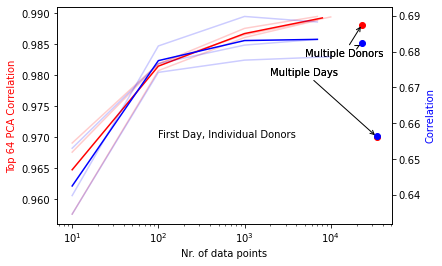

In [271]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot([10,100,1000,7000],[0.96761,0.98178,0.98751,0.98943],color='r',alpha=0.2)
ax.plot([10,100,1000,10000],[0.96908,0.98183,0.98647,0.98935],color='r',alpha=0.2)
ax.plot([10,100,1000,7000],[0.95765,0.98072,0.98605,0.98880],color='r',alpha=0.2)
ax.plot([10,100,1000,8000],[0.96478,0.98144333,0.98667667,0.98919333],color='r')
ax.scatter([23000],[0.98810],color='r')
ax.scatter([34000],[0.97012],color='r')
ax.set_xscale('log')
ax.set_xlabel('Nr. of data points')
ax.set_ylabel('Top 64 PCA Correlation',color='r')
ax2 = ax.twinx()
ax2.plot([10,100,1000,7000],[0.63974,0.68156,0.68981,0.68826],color='b',alpha=0.2)
ax2.plot([10,100,1000,10000],[0.63456,0.67418,0.67760,0.67854],color='b',alpha=0.2)
ax2.plot([10,100,1000,7000],[0.65297,0.67664,0.68180,0.68341],color='b',alpha=0.2)
ax2.plot([10,100,1000,7000],[0.64242333,0.67746,0.68307,0.68340333],color='b')
ax2.scatter([23000],[0.68246], color='b')
ax2.scatter([34000],[0.65642], color='b')
ax2.set_ylabel('Correlation',color='b')
ax.annotate("Multiple Donors", xy=(23000, 0.98810), xytext=(5000, 0.983),
            arrowprops=dict(arrowstyle="->"))
ax.annotate("Multiple Donors", xy=(23000, 0.9850), xytext=(5000, 0.983),
            arrowprops=dict(arrowstyle="->"))
ax.annotate("Multiple Days", xy=(34000, 0.97012), xytext=(2000, 0.980),
            arrowprops=dict(arrowstyle="->"))
ax.annotate("Multiple Days", xy=(2000, 0.980))
ax.annotate("First Day, Individual Donors", xy=(100, 0.970))

Text(5.2, 0.97, 'Same Day, Same Donor')

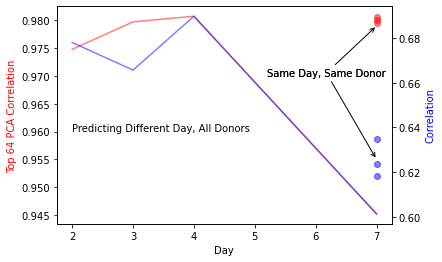

In [208]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot([2,3,4,7],[0.97480,0.97973,0.98074,0.94519],color='r',alpha=0.5)
ax.scatter([7],[0.98054],color='r',alpha=0.5)
ax.scatter([7],[0.98007],color='r',alpha=0.5)
ax.scatter([7],[0.97959],color='r',alpha=0.5)


ax.set_xlabel('Day')
ax.set_ylabel('Top 64 PCA Correlation',color='r')
ax2 = ax.twinx()
ax2.plot([2,3,4,7],[0.67806,0.66570,0.68982,0.60127],color='b',alpha=0.5)
ax2.scatter([7],[0.62380],color='b',alpha=0.5)
ax2.scatter([7],[0.63471],color='b',alpha=0.5)
ax2.scatter([7],[0.61805],color='b',alpha=0.5)

ax2.set_ylabel('Correlation',color='b')
ax.annotate("Predicting Different Day, All Donors", xy=(2, 0.96))
ax.annotate("Same Day, Same Donor", xy=(7, 0.979), xytext=(5.2, 0.970),
            arrowprops=dict(arrowstyle="->"))
ax.annotate("Same Day, Same Donor", xy=(7, 0.955), xytext=(5.2, 0.970),
            arrowprops=dict(arrowstyle="->"))

<AxesSubplot:>

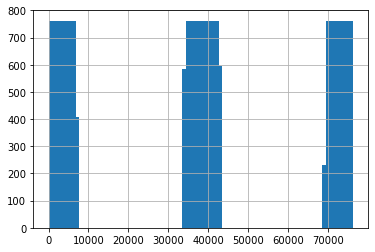

In [18]:
with np.load('../sparse/train_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index = data['index']
metadata_df = pd.read_csv('../../input/open-problems-multimodal/metadata.csv', index_col='cell_id')
metadata_df = metadata_df[metadata_df.technology=="multiome"]
meta = metadata_df.reindex(cell_index)
meta['range'] = range(len(meta))
meta.loc[meta.day == 2].range.hist(bins=100)

In [45]:
donor1 = meta.loc[meta.donor == 32606].range.values

In [46]:
len(donor1)

33701

In [221]:
day7_donor3 = meta.loc[(meta.day == 7)&(meta.donor == 31800)].range.values

In [222]:
day4_donor3 = meta.loc[(meta.day == 4)&(meta.donor == 31800)].range.values

In [274]:
donor1_day7 = meta.loc[(meta.day == 7)&(meta.donor == 32606)].range.values

In [58]:
meta.donor.unique()

array([32606, 13176, 31800])

<AxesSubplot:>

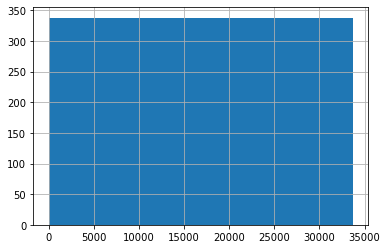

In [48]:
meta.loc[meta.donor == 13176].range.hist(bins=100)

In [209]:
len(day2)

23911

In [303]:
meta.groupby(['day','cell_type']).donor.count().unstack()

cell_type,BP,EryP,HSC,MasP,MkP,MoP,NeuP
day,,,,,,,
2,262,3402,10757,2175,3394,258,3663
3,121,4699,11167,3549,2886,498,5895
4,123,6054,9116,5228,3495,462,6656
7,60,2980,3621,5785,3446,843,5347


In [311]:
types_day7 = meta.groupby(['day','cell_type']).donor.count().unstack().loc[7]

In [307]:
types_day7 = types_day7/types_day7.sum()

In [312]:
types_day7

cell_type
BP        60
EryP    2980
HSC     3621
MasP    5785
MkP     3446
MoP      843
NeuP    5347
Name: 7, dtype: int64

In [309]:
types_day4 = meta.groupby(['day','cell_type']).donor.count().unstack().loc[4]
types_day4 = types_day4/types_day4.sum()

In [313]:
types_day4 = meta.groupby(['day','cell_type']).donor.count().unstack().loc[4]
types_day4

cell_type
BP       123
EryP    6054
HSC     9116
MasP    5228
MkP     3495
MoP      462
NeuP    6656
Name: 4, dtype: int64

other than MasP and MoP, have more cells on day 4 of each type.

In [314]:
types_day7_donor1 = meta.loc[meta.donor == 32606].groupby(['day','cell_type']).donor.count().unstack().loc[7]

In [315]:
types_day7_donor1

cell_type
BP        14
EryP     851
HSC     1060
MasP    2240
MkP      906
MoP      206
NeuP    1683
Name: 7, dtype: int64

In [316]:
types_day4 = meta.loc[meta.donor == 32606].groupby(['day','cell_type']).donor.count().unstack().loc[4]
types_day4

cell_type
BP        40
EryP    2153
HSC     2991
MasP    2093
MkP     1125
MoP      123
NeuP    2408
Name: 4, dtype: int64

same thing. I can just get 1/2 the cells from day 7 and then match.

In [318]:
(types_day7_donor1/2).astype(int)

cell_type
BP         7
EryP     425
HSC      530
MasP    1120
MkP      453
MoP      103
NeuP     841
Name: 7, dtype: int64

In [324]:
frame = pd.DataFrame()
for type in types_day7_donor1.index:
    frame = frame.append(meta.loc[(meta.donor == 32606) & (meta.day == 4) & (meta.cell_type == type)][:(types_day7_donor1/2).astype(int).loc[type]])

In [335]:
match_type_day4_to_day7 = frame.range.values

In [37]:
(y_va_pred@svd.components_).shape

(1000, 22858)

In [38]:
targets[].shape

(105942, 22858)

In [223]:
X_tr = X_copy[day4_donor3][:1000,:40]
X_va = X_copy[day7_donor3][:1000,:40]
y_tr = svd.transform(targets_copy[day4_donor3][:1000])[:,:64]
y_va = svd.transform(targets_copy[day7_donor3][:1000])[:,:64]
targets = targets_copy[day7_donor3][:1000]
print(X_tr.shape)
print(y_va.shape)
print(targets.shape)
Y = y_tr
X = X_tr

(1000, 40)
(1000, 64)
(1000, 22858)


In [224]:
import warnings
warnings.filterwarnings("ignore")

VERBOSE = 0
N_SPLIT = 3
#kf = KFold(n_splits=N_SPLIT, shuffle=True, random_state=42)
kf = KFold(n_splits = N_SPLIT)

scores = []
pca_scores = []
pred_train = np.zeros_like(Y)

model = create_model()

lr = ReduceLROnPlateau(
            monitor = "val_loss",
            factor = 0.9, 
            patience = 4, 
            verbose = VERBOSE)

es = EarlyStopping(
            monitor = "val_loss",
            patience = 30, 
            verbose = VERBOSE,
            mode = "min", 
            restore_best_weights = True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss = 'mse',
              metrics=None)
model.fit(X_tr,
          y_tr,
          validation_data=(X_va,y_va),
          epochs =500,
          verbose = VERBOSE,
          batch_size=256,
          callbacks = [es,lr]
         )
y_va_pred = model.predict(X_va)
corrscore = correlation_score(targets, y_va_pred@svd.components_[:64])
scores.append(corrscore)
pca_corrscore = correlation_score(y_va[:,:64], y_va_pred[:,:64])
pca_scores.append(pca_corrscore)

print(f'Mean squared error = {np.round(mean_squared_error(y_va,y_va_pred),2)}')
print(f'Correlation = {corrscore:.5f}')
print(f'PCA Correlation = {pca_corrscore:.5f}')

del X_tr,X_va,y_tr,y_va
gc.collect()

# Show overall score
print(f"{Fore.GREEN}{Style.BRIGHT}Mean corr = {np.array(scores).mean():.5f}{Style.RESET_ALL}")
print(f"{Fore.RED}{Style.BRIGHT}Mean pca corr = {np.array(pca_scores).mean():.5f}{Style.RESET_ALL}")
# score_total = correlation_score(targets, pred_train@svd.components_)#pred_train@pca_target_comps)
# print(f"{Fore.BLUE}{Style.BRIGHT}Oof corr   = {score_total:.5f}{Style.RESET_ALL}")

32/32 [==============================] - 0s 2ms/step
Mean squared error = 13.100000381469727
Correlation = 0.60073
PCA Correlation = 0.95909
Mean corr = 0.60073
Mean pca corr = 0.95909


In [225]:
(0.61023+0.61940+0.60073)/3

0.61012

Text(3.8, 0.61012, 'Just using day 4 to predict day 7')

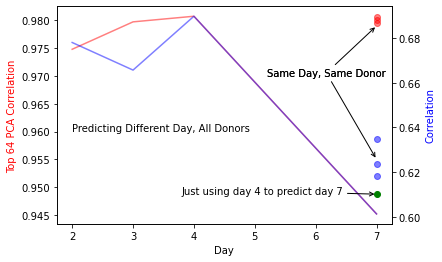

In [232]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot([2,3,4,7],[0.97480,0.97973,0.98074,0.94519],color='r',alpha=0.5)
ax.scatter([7],[0.98054],color='r',alpha=0.5)
ax.scatter([7],[0.98007],color='r',alpha=0.5)
ax.scatter([7],[0.97959],color='r',alpha=0.5)


ax.set_xlabel('Day')
ax.set_ylabel('Top 64 PCA Correlation',color='r')
ax2 = ax.twinx()
ax2.plot([2,3,4,7],[0.67806,0.66570,0.68982,0.60127],color='b',alpha=0.5)
ax2.scatter([7],[0.62380],color='b',alpha=0.5)
ax2.scatter([7],[0.63471],color='b',alpha=0.5)
ax2.scatter([7],[0.61805],color='b',alpha=0.5)
ax2.scatter([7],[0.61012],color='g')

ax2.set_ylabel('Correlation',color='b')
ax.annotate("Predicting Different Day, All Donors", xy=(2, 0.96))
ax.annotate("Same Day, Same Donor", xy=(7, 0.979), xytext=(5.2, 0.970),
            arrowprops=dict(arrowstyle="->"))
ax.annotate("Same Day, Same Donor", xy=(7, 0.955), xytext=(5.2, 0.970),
            arrowprops=dict(arrowstyle="->"))
ax2.annotate("Just using day 4 to predict day 7", xy=(7, 0.61012), xytext=(3.8, 0.61012),
            arrowprops=dict(arrowstyle="->"))

In [86]:
svd7 = TruncatedSVD(n_components = 512,random_state = 1)
svd7.fit(targets_copy[day7_donor1])
svd4 = TruncatedSVD(n_components = 8192,random_state = 1)
svd4.fit(targets_copy[day4_donor1])

TruncatedSVD(n_components=8192, random_state=1)

In [56]:
abc = np.zeros((64,64))
for i in range(64):
    for j in range(64):
        abc[i,j]=np.abs(svd7.components_[i].T@svd4.components_[j])

<AxesSubplot:>

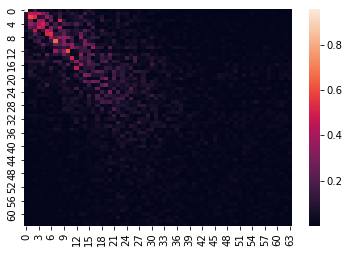

In [51]:
import seaborn as sns
sns.heatmap(abc)

In [99]:
abc = np.zeros((64,64))
for i in range(64):
    for j in range(64):
        abc[i,j]=svd7.components_[i].T@svd4.components_[j]

In [100]:
#64
np.sum(list(map(lambda x: x**2,abc)),axis=1)

array([0.970315  , 0.8749559 , 0.89457078, 0.82203718, 0.85565294,
       0.82470973, 0.81558348, 0.82076067, 0.77151775, 0.76123261,
       0.70432448, 0.55039052, 0.73287444, 0.54183051, 0.52112397,
       0.45981548, 0.38127695, 0.39127293, 0.3201854 , 0.32774585,
       0.2916771 , 0.32436252, 0.26453652, 0.21748206, 0.22149012,
       0.20359454, 0.20107628, 0.17341163, 0.11240417, 0.1168107 ,
       0.08759054, 0.09189415, 0.07041828, 0.08057394, 0.07988457,
       0.06247781, 0.05212354, 0.03859794, 0.04982894, 0.03203417,
       0.03829722, 0.01938023, 0.01601375, 0.01960265, 0.02719193,
       0.01720226, 0.02159923, 0.0252655 , 0.01451398, 0.01315323,
       0.01857382, 0.01427119, 0.01335309, 0.01321295, 0.01410719,
       0.01592213, 0.01390831, 0.00908235, 0.01255288, 0.01878934,
       0.01179975, 0.01466252, 0.0150678 , 0.01205141])

In [82]:
#512
np.sum(list(map(lambda x: x**2,abc)),axis=1)

array([0.9723027 , 0.88380502, 0.9014982 , 0.83551972, 0.86581434,
       0.83696521, 0.82898102, 0.83325219, 0.79047059, 0.77667957,
       0.7233538 , 0.58391449, 0.74885901, 0.5772288 , 0.55682732,
       0.50368256, 0.43537332, 0.43647988, 0.37667437, 0.39213958,
       0.34909401, 0.37738143, 0.31881038, 0.28028805, 0.27570007,
       0.2605048 , 0.25813959, 0.2333965 , 0.18341824, 0.18425963,
       0.15539695, 0.17191626, 0.13946587, 0.13919582, 0.1529572 ,
       0.12829921, 0.12570153, 0.10423331, 0.10800357, 0.09594738,
       0.09955492, 0.0814841 , 0.07807637, 0.08160591, 0.08369063,
       0.07947562, 0.07839625, 0.08158901, 0.06503121, 0.06670253,
       0.07266515, 0.07509248, 0.06472812, 0.07111115, 0.0769469 ,
       0.07719336, 0.06935187, 0.06482946, 0.07124681, 0.07468348,
       0.06679965, 0.07086716, 0.07548687, 0.06864403])

In [85]:
#2048
np.sum(list(map(lambda x: x**2,abc)),axis=1)

array([0.97823989, 0.9048074 , 0.9208459 , 0.86884294, 0.89180421,
       0.86556562, 0.86321808, 0.86441437, 0.83194793, 0.81933092,
       0.77290556, 0.66932046, 0.79414046, 0.66216089, 0.64768464,
       0.60958698, 0.55497603, 0.55642536, 0.50605089, 0.51753105,
       0.4821002 , 0.50746135, 0.46754607, 0.43088958, 0.4216331 ,
       0.41250448, 0.419917  , 0.38126904, 0.35365288, 0.3452323 ,
       0.33633963, 0.34201884, 0.31552302, 0.31120169, 0.31628348,
       0.30370318, 0.29299124, 0.274826  , 0.28471257, 0.26779673,
       0.27916602, 0.25425863, 0.24690766, 0.26863535, 0.2627179 ,
       0.25365823, 0.25914985, 0.24347159, 0.24812546, 0.24591915,
       0.23964493, 0.23802975, 0.24276231, 0.2537071 , 0.2507747 ,
       0.25205459, 0.24592212, 0.24636781, 0.24823473, 0.24990152,
       0.24150606, 0.24443466, 0.25637897, 0.24630266])

In [88]:
#8192
np.sum(list(map(lambda x: x**2,abc)),axis=1)

array([0.99160531, 0.95965542, 0.96689074, 0.94577794, 0.95485573,
       0.94418313, 0.94520619, 0.9446044 , 0.92984212, 0.92675368,
       0.90606309, 0.86988807, 0.91512451, 0.86410246, 0.86189175,
       0.84427009, 0.822389  , 0.82221459, 0.80927035, 0.80764813,
       0.79528308, 0.80734935, 0.78914247, 0.78351596, 0.77458149,
       0.77422268, 0.77624821, 0.77086206, 0.75403049, 0.75234508,
       0.74358779, 0.75647484, 0.74213305, 0.74577602, 0.74793391,
       0.73894003, 0.73831438, 0.73277275, 0.73615701, 0.72923367,
       0.73857243, 0.72385342, 0.72093128, 0.72720294, 0.72570304,
       0.7158628 , 0.7193619 , 0.71431562, 0.72098842, 0.71451657,
       0.71799517, 0.71453529, 0.71327977, 0.71886818, 0.71380471,
       0.71773727, 0.71513085, 0.72312934, 0.72899874, 0.71608245,
       0.72482263, 0.7240383 , 0.72738176, 0.71017327])

In [189]:
day2_donor1 = meta.loc[(meta.day == 2)&(meta.donor == 32606)].range.values
svd2 = TruncatedSVD(n_components = 512,random_state = 1)
svd2.fit(targets_copy[day2_donor1])

TruncatedSVD(n_components=512, random_state=1)

In [200]:
abc42 = np.zeros((64,64))
for i in range(64):
    for j in range(64):
        abc42[i,j]=np.abs(svd4.components_[i].T@svd2.components_[j])

<AxesSubplot:>

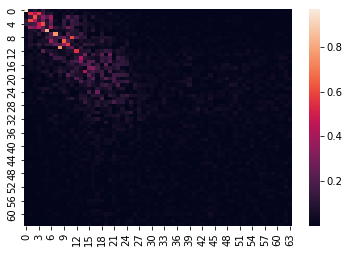

In [201]:
sns.heatmap(abc42)

In [196]:
#64
np.sum(list(map(lambda x: x**2,abc)),axis=1)

array([0.98141524, 0.86381045, 0.85643398, 0.85248812, 0.81142174,
       0.798585  , 0.79980476, 0.74910394, 0.662178  , 0.69692048,
       0.6833631 , 0.67310181, 0.49006905, 0.31897331, 0.40192349,
       0.39109755, 0.30365216, 0.34197657, 0.37947486, 0.28585079,
       0.25227846, 0.19537911, 0.1702898 , 0.09294644, 0.14120365,
       0.14240542, 0.12269096, 0.1398505 , 0.0593438 , 0.05813758,
       0.06813368, 0.04730829, 0.04615724, 0.02939941, 0.01846747,
       0.02306522, 0.01782275, 0.02097389, 0.01813932, 0.01515638,
       0.0152199 , 0.0095405 , 0.01092064, 0.01373413, 0.01138718,
       0.01289659, 0.00871   , 0.00770414, 0.00960849, 0.01009915,
       0.00858137, 0.00989233, 0.00959406, 0.00989085, 0.01044584,
       0.00672242, 0.01313331, 0.00598081, 0.0059037 , 0.00968947,
       0.01554411, 0.0057418 , 0.00880748, 0.00944052])

In [203]:
abc72 = np.zeros((64,64))
for i in range(64):
    for j in range(64):
        abc72[i,j]=np.abs(svd7.components_[i].T@svd2.components_[j])

<AxesSubplot:>

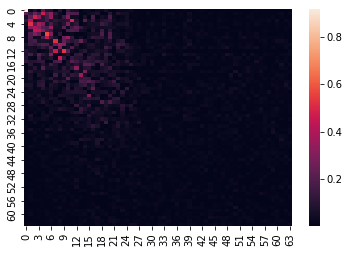

In [204]:
sns.heatmap(abc72)

In [206]:
abc74 = np.zeros((64,64))
for i in range(64):
    for j in range(64):
        abc74[i,j]=svd7.components_[i].T@svd4.components_[j]

Text(0, 0.5, 'explained variance')

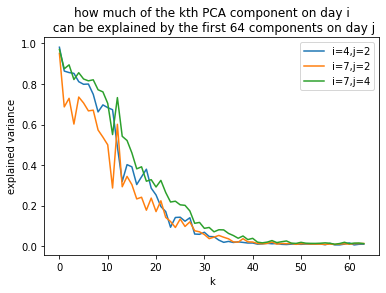

In [214]:
plt.plot(np.sum(list(map(lambda x: x**2,abc42)),axis=1),label='i=4,j=2')
plt.plot(np.sum(list(map(lambda x: x**2,abc72)),axis=1),label='i=7,j=2')
plt.plot(np.sum(list(map(lambda x: x**2,abc74)),axis=1),label='i=7,j=4')
plt.legend()
plt.title('how much of the kth PCA component on day i\n can be explained by the first 64 components on day j')
plt.xlabel('k')
plt.ylabel('explained variance')